In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from threeML import *
import numpy as np
from threeML.plugins import *
from skylab.datasets import Datasets
from astropy import units as u
from imp import reload
import scipy.optimize
import mla.core
import mla.injection
import mla.spectral
import warnings
import numpy.lib.recfunctions as rf
warnings.filterwarnings("ignore")
from skylab.ps_llh import PointSourceLLH
from skylab.llh_models import PowerLawLLH,EnergyLLH,ClassicLLH
from skylab.ps_injector import PointSourceInjector
import logging
skylab_logger = logging.getLogger('skylab')
skylab_logger.setLevel(logging.CRITICAL)

import os, sys, glob, abc

def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
exp = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
mc = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
exp['angErr'][exp['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
mc['angErr'][mc['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

exp['ra']=np.random.uniform(0,2*np.pi,size=len(exp))
grl = np.load("/data/i3store/users/mjlarson/student_data/GRL/IC86_2012_exp.npy")
livetime = np.sum(grl['livetime'])
exp=rf.append_fields(exp.copy(),
                           'sigma',
                           exp['angErr'],
                           dtypes=np.float32)
mc=rf.append_fields(mc.copy(),
                           'sigma',
                           mc['angErr'],
                           dtypes=np.float32)
exp=rf.append_fields(exp.copy(),
                           'sinDec',
                           np.sin(exp['dec']),
                           dtypes=np.float32)
mc=rf.append_fields(mc.copy(),
                           'sinDec',
                           np.sin(mc['dec']),
                           dtypes=np.float32)

In [26]:
ra=np.radians(83.63)
dec=np.radians(22.0145)

In [27]:
inj = PointSourceInjector(gamma = 2., E0 = 1000.)
inj.fill(dec, exp, mc, livetime)

In [28]:

testskylab_model=EnergyLLH(twodim_bins=100)#twodim_bins=100)
#testskylab_model=ClassicLLH()
testskylab=PointSourceLLH.upscale(exp,mc,(livetime,100),testskylab_model,seed=1)

In [29]:
#testskylab._exp = np.load("testdata.npy")
testskylab.fit_source(ra,dec)

(0.0, {'nsignal': 0.0, 'gamma': 2.467278692488895})

In [30]:
ni,sample =  inj.sample(src_ra=ra, mean_signal=15, poisson=False)
sample['time']=1
testskylab.pseudo_experiment(inject=sample)
#tempresult=testskylab.fit_source(ra,dec,inject=sample, scramble=True)

In [31]:
np.save("testdata",testskylab._exp)

In [32]:
a=testskylab.fit_source(ra,dec)
a

(79.55811672498429, {'nsignal': 22.1550180768072, 'gamma': 2.2281325688125424})

In [37]:
events = testskylab._exp[:10000]
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
n=0
for i in range(100):
    for j in range(100):
        events[n]['sinDec']=sindec[i]
        events[n]['logE']=logE[j]
        n+=1
        
e, _ = testskylab.llh_model.weight(events, gamma=2.0)        # energy s/b with fit gamma. Fixed in Liz's analysis to 2.0
ratio=np.reshape(e,(100,100))

In [40]:
events

array([(122056, 21611976, 0, 5.84012754, -0.35361759, 0.91414601, 1.2170029 , 56368.13394145, 1.        , 0.00349066, 0.00349066, -1., 0.04262827),
       (120810, 80439129, 0, 3.45238657, -0.14157806, 4.07332498, 1.42924205, 56215.57880173, 1.07070707, 0.00724975, 0.00724975, -1., 0.04654627),
       (122230, 31298798, 0, 5.75546257,  0.2637602 , 4.36751218, 1.8341741 , 56403.15767888, 1.14141414, 0.0108782 , 0.0108782 , -1., 0.12322199),
       ...,
       (121663, 17538787, 0, 3.44943758,  0.65925886, 1.73056223, 2.22933873, 56306.03851652, 7.85858586, 0.01854126, 0.01854126,  1., 0.08112729),
       (120264, 29567749, 2, 1.36130982,  0.24471672, 0.4683939 , 1.81535461, 56084.83532773, 7.92929293, 0.00558896, 0.00558896,  1., 0.12471679),
       (121879, 33689489, 0, 5.92895868,  0.35125319, 5.0857664 , 1.92181114, 56337.4420022 , 8.        , 0.0133782 , 0.0133782 ,  1., 0.10948342)],
      dtype=[('run', '<i8'), ('event', '<i8'), ('subevent', '<i8'), ('ra', '<f8'), ('dec', '<f8'), 

In [23]:
ddd=np.load("temp.npy")
e, _ = testskylab.llh_model.weight(ddd, gamma=2.0)
np.save("energyskylab.npy",e)

In [19]:
testskylab.update_model(testskylab.llh_model,ddd)
testskylab.fit_source(ra,dec)

(424.59492323597215, {'nsignal': 1000.0, 'gamma': 2.1951616471370268})

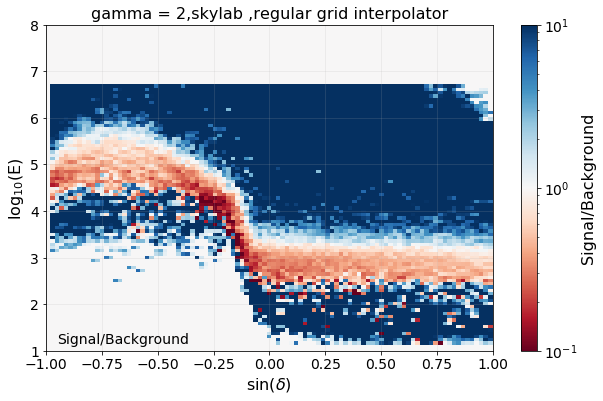

In [34]:
from matplotlib import pyplot as plt, colors
fig, ax = plt.subplots(figsize=(10,6))
sindec=np.linspace(-1,1,100)
logE=np.linspace(1,8,100)
cmesh = ax.pcolormesh(np.linspace(-1,1,100), np.linspace(1,8,100), ratio.T,
                     cmap = 'RdBu',
                     norm = colors.LogNorm(),
                     vmin = 1e1,
                     vmax = 1e-1)
cbar = plt.colorbar(cmesh, ax=ax)
ax.text(-0.95, 1.1, 
        "Signal/Background",
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=14)
ax.grid(alpha=0.2)
ax.set_xlabel(r"sin($\delta$)", fontsize=16)
ax.set_ylabel(r"log$_{10}$(E)", fontsize=16)
ax.tick_params(which='both', labelsize=14)
ax.set_title(r"gamma = 2,skylab ,regular grid interpolator", fontsize=16)
cbar.ax.set_ylabel("Signal/Background", fontsize=16)
cbar.ax.tick_params(labelsize=14)
#np.save()

In [41]:
ns = np.linspace(1,40,100)
gamma = np.linspace(1.5,3.5,40)
tempresult=np.zeros((100,40))
result=[]
for i,ga in enumerate(gamma):
    for j,nss in enumerate(ns):
        temp=testskylab.llh(nsignal=nss,gamma=ga)
        result.append([ga,nss,nss,temp[0]*2])
        tempresult[j][i]=temp[0]*2
    

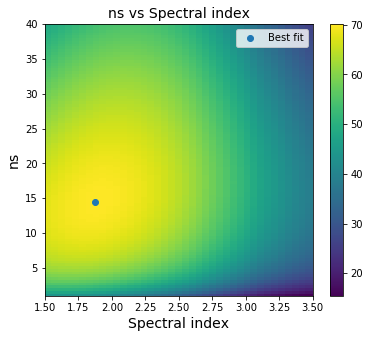

In [42]:
result=np.array(result)
x=result[:,0]
y=result[:,1]
z=result[:,3]
ns = np.linspace(1,40,100)
gamma = np.linspace(1.5,3.5,40)
## Equivalently, we could do that all in one line with:
# x,y,z = np.genfromtxt('eye_.txt', delimiter=',', usecols=(0,1,2))
z[z<0]=0
x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z=z.reshape(len(y),len(x))
#index=result[np.argmax(result[:,3])]
index=np.unravel_index(tempresult.argmax(), tempresult.shape)
fig, ax = plt.subplots(figsize = (6,5))
plt.pcolormesh(X,Y,tempresult)
plt.colorbar()
#plt.scatter(gamma[index[1]],ns[index[0]],label="Best fit")
plt.scatter(a[1]['gamma'],a[1]['nsignal'],label="Best fit")
plt.title("ns vs Spectral index",fontsize=14)
plt.xlabel(r"Spectral index",fontsize=14)
plt.ylabel("ns",fontsize=14)
plt.legend()
plt.show()

In [56]:
in_ns=np.arange(5,101)
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        ni,sample =  inj.sample(src_ra=ra, mean_signal=ns, poisson=False)
        sample['time']=1
        tempresult=testskylab.fit_source(ra,dec,inject=sample, scramble=True)
        result.append((inject_ns,tempresult[1]['gamma'],tempresult[1]['nsignal'],tempresult[0]))
    return np.array(result)

In [ ]:
injectns(15)

In [ ]:
from multiprocessing import Pool
p=Pool(30)
warnings.filterwarnings("ignore")
allresult=p.map(injectns,in_ns)

allresult=np.array(allresult)
np.save("allresult_skylab_2.npy",allresult)
p.close()

In [ ]:
gamma_list=[]
ts_list=[]
ns_list=[]
for i in range(allresult.shape[0]):
    ns_inject=allresult[i][0][0]
    gamma=allresult[i][:,1]
    ts=(-allresult[i][:,3])
    ns=allresult[i][:,2]
    gamma_list.append(np.array([gamma.mean(),gamma.std()]))
    ts_list.append(np.array([ts.mean(),ts.std()]))
    ns_list.append(np.array([ns.mean(),ts.std()]))

    
gamma_list=np.array(gamma_list)
ts_list=np.array(ts_list)
ns_list=np.array(ns_list)

In [13]:
inj = PointSourceInjector(gamma = 2.5, E0 = 1000.)
inj.fill(dec, exp, mc, livetime)
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        ni,sample =  inj.sample(src_ra=ra, mean_signal=ns, poisson=False)
        sample['time']=1
        tempresult=testskylab.fit_source(ra,dec,inject=sample, scramble=True)
        result.append((inject_ns,tempresult[1]['gamma'],tempresult[1]['nsignal'],tempresult[0]))
    return np.array(result)
p=Pool(30)
allresult25=p.map(injectns,in_ns)
allresult25=np.array(allresult25)
np.save("allresult2.5_skylab_2.npy",allresult25)
p.close()


gamma_list25=[]
ts_list25=[]
ns_list25=[]
for i in range(allresult25.shape[0]):
    ns_inject=allresult25[i][0][0]
    gamma=allresult25[i][:,1]
    ts=(-allresult25[i][:,3])
    ns=allresult25[i][:,2]
    gamma_list25.append(np.array([gamma.mean(),gamma.std()]))
    ts_list25.append(np.array([ts.mean(),ts.std()]))
    ns_list25.append(np.array([ns.mean(),ts.std()]))

    
gamma_list25=np.array(gamma_list25)
ts_list25=np.array(ts_list25)
ns_list25=np.array(ns_list25)


inj = PointSourceInjector(gamma = 3., E0 = 1000.)
inj.fill(dec, exp, mc, livetime)
def injectns(inject_ns):
    result = []
    ns=inject_ns
    for i in range(100):
        ni,sample =  inj.sample(src_ra=ra, mean_signal=ns, poisson=False)
        sample['time']=1
        tempresult=testskylab.fit_source(ra,dec,inject=sample, scramble=True)
        result.append((inject_ns,tempresult[1]['gamma'],tempresult[1]['nsignal'],tempresult[0]))
    return np.array(result)
p=Pool(30)
allresult3=p.map(injectns,in_ns)
allresult3=np.array(allresult3)
np.save("allresult3_skylab_2.npy",allresult3)
p.close()


gamma_list3=[]
ts_list3=[]
ns_list3=[]
for i in range(allresult3.shape[0]):
    ns_inject=allresult3[i][0][0]
    gamma=allresult3[i][:,1]
    ts=(-allresult3[i][:,3])
    ns=allresult3[i][:,2]
    gamma_list3.append(np.array([gamma.mean(),gamma.std()]))
    ts_list3.append(np.array([ts.mean(),ts.std()]))
    ns_list3.append(np.array([ns.mean(),ts.std()]))

    
gamma_list3=np.array(gamma_list3)
ts_list3=np.array(ts_list3)
ns_list3=np.array(ns_list3)


In [19]:
-gamma_list[:,0]

array([-2.08257209, -2.05213328, -2.04037582, -2.07438662, -2.10851756,
       -2.10969703, -2.12419919, -2.13065924, -2.13992202, -2.12069935,
       -2.0994535 , -2.11410311, -2.09838446, -2.10305253, -2.09986601,
       -2.09613614, -2.10439404, -2.10150342, -2.09415521, -2.09382417,
       -2.09456724, -2.09525305, -2.09858337, -2.09819507, -2.10261177,
       -2.10101908, -2.10307345, -2.10648191, -2.10544211, -2.10284554,
       -2.11413385, -2.11490107, -2.11826876, -2.11516085, -2.10709501,
       -2.10878399, -2.11408608, -2.10545764, -2.11139255, -2.1129093 ,
       -2.10695446, -2.10662776, -2.11353479, -2.10868047, -2.1071244 ,
       -2.10091828, -2.10777044, -2.11174286, -2.10608905, -2.10803763,
       -2.09657623, -2.10601197, -2.10828458, -2.10878108, -2.09736813,
       -2.10633187, -2.10302584, -2.09850613, -2.0997942 , -2.09779984,
       -2.09442436, -2.09224688, -2.08348008, -2.08595211, -2.08276785,
       -2.08349248, -2.08204442, -2.08293369, -2.08286261, -2.07

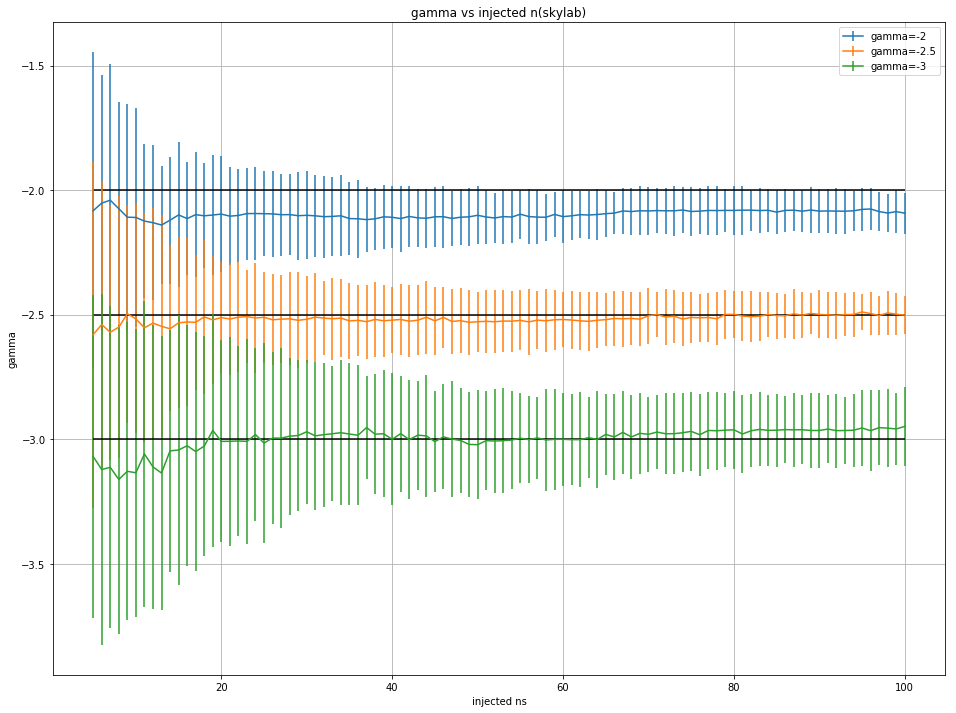

In [16]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, -gamma_list[:,0],
            yerr=gamma_list[:,1],
            fmt='-',label="gamma=-2")


ax.hlines(-2,5,100)
ax.errorbar(in_ns, -gamma_list25[:,0],
            yerr=gamma_list25[:,1],
            fmt='-',label="gamma=-2.5")
ax.hlines(-2.5,5,100)
ax.errorbar(in_ns, -gamma_list3[:,0],
            yerr=gamma_list3[:,1],
            fmt='-',label="gamma=-3")
ax.hlines(-3,5,100)
ax.set_xlabel("injected ns")
ax.set_ylabel("gamma")
ax.set_title("gamma vs injected n(skylab)")
ax.legend()
plt.grid()

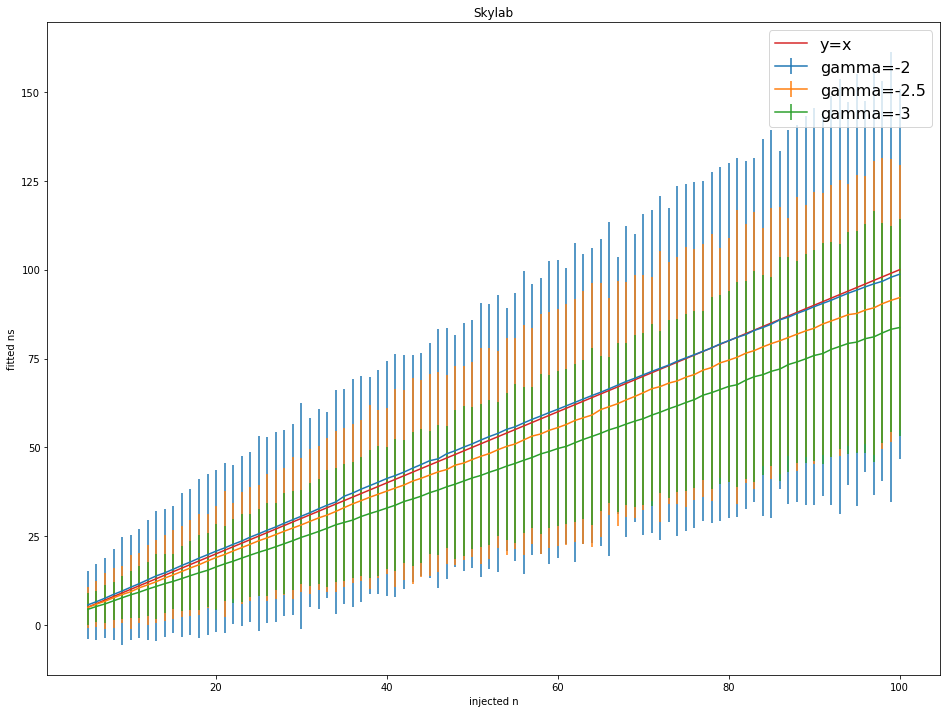

In [20]:
fig, ax = plt.subplots(figsize=(16,12))


ax.errorbar(in_ns, ns_list[:,0],
            yerr=ns_list[:,1],
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=ns_list25[:,1],
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=ns_list3[:,1],
            fmt='-',label="gamma=-3")
# ax.errorbar(in_ns, ns_list[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-2")
# ax.errorbar(in_ns, ns_list25[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-2.5")

# ax.errorbar(in_ns, ns_list3[:,0],
#             yerr=0,
#             fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected n")
ax.set_ylabel("fitted ns")
ax.set_title("Skylab")
ax.legend(fontsize=16)

NameError: name 'ns_list' is not defined

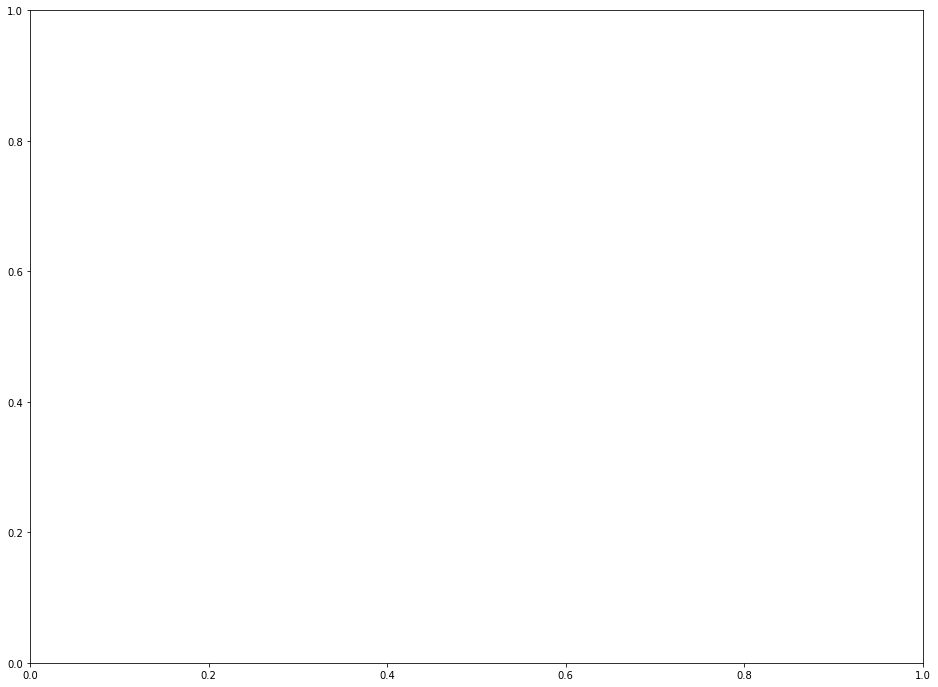

In [44]:
fig, ax = plt.subplots(figsize=(16,12))

in_ns = np.linspace(1,40,100)

ax.errorbar(in_ns, ns_list[:,0],
            yerr=0,
            fmt='-',label="gamma=-2")
ax.errorbar(in_ns, ns_list25[:,0],
            yerr=0,
            fmt='-',label="gamma=-2.5")

ax.errorbar(in_ns, ns_list3[:,0],
            yerr=0,
            fmt='-',label="gamma=-3")


x=np.linspace(5,100,1000)
ax.plot(x,x,label="y=x")
ax.set_xlabel("injected n")
ax.set_ylabel("fitted ns")
ax.set_title("Skylab")
ax.legend(fontsize=16)